# Yield Prediction using fingerprint (DRFP) data_set_condensation_reaction

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd 
import os 
import sys
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.ML.Descriptors.Descriptors import DescriptorCalculator
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from drfp import DrfpEncoder
import shap
import cairo
import pandas as pd
import seaborn as sns
IPythonConsole.molSize = (300, 300)
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p
shap.initjs()

Found this dataset from a recent publication by a D.M. Makarov et al. (Journal of Computational Science 74 (2023) 102173) (https://doi.org/10.1016/j.jocs.2023.102173)

"""We considered pyrrole or dipyrromethane condensation reactions with various aldehydes, resulting in the production of boron(III) dipyrromethene or BODIPY (681 records). These reactions were retrieved from articles (see “Dataset reactions” and Scheme S1). Addi tionally, we used the reactions of the production of dipyrromethane (111 records) and porphyrins (457 records). All condensation reactions for dipyrromethanes and 213 reactions for porphyrins with various al dehydes were obtained in our laboratory. The remaining 244 reactions for the porphyrins synthesis were obtained from articles (see “Dataset reactions”). Our experimental dataset is based on a study of pyrrole condensation processes with aldehydes, using catalytic amounts of organic acids to produce ms-aryl- and ß-alkyl-substituted dipyrro methanes. """

The objective of this notebook is to introduce a method for predicting yield

As a beginner, there may be numerous opportunities for improvement in this notebook. I was largely inspired by the work of D.M. Makarov et al and by the work of Alexander A. Ksenofontov and co (10.1016/j.jocs.2023.102173),Jean-Louis Reymond and co (10.1039/d1dd00006c) and the André OLIVEIRA's notebook (Predicting molecule properties based on its SMILES), thanks to them.

## Data

In [2]:
data = r"C:\Users\loris\Desktop\IA_chemistry\Dipyrromethanes_condensation_reactions-main\Condensation_reactions - Copie.xlsx"
dataF = pd.read_excel(data)

df = dataF.copy()

df.shape

(1249, 4)

In [3]:
df.head()

,SMILES,yield,Temperature,Ind
0,CC(C)(C)c1ccc(OCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C=...,0.05,20,78
1,O=Cc1ccccc1OCCOC(=O)C#CC(=O)OCCOc1ccccc1C=O.c1...,1.00,40,909
2,c1cc[nH]c1.Cc1cc(C)c(C=O)c(C)c1.COC(=O)c1ccc(C...,2.00,20,747
3,CC(C)(C)c1ccc(OCCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C...,2.10,20,77
4,Cc1ccc(-c2ccccc2C=O)cc1.Fc1c(F)c(F)c(C(c2ccc[n...,2.50,25,266


In [4]:
df.columns

Index(['SMILES', 'yield', 'Temperature', 'Ind'], dtype='object')

## Missing values

In [5]:
missing_values = df.isna().sum() 
missing_values

SMILES         0
yield          0
Temperature    0
Ind            0
dtype: int64

## target

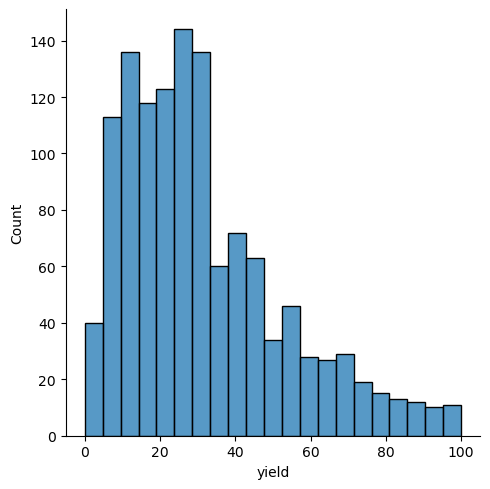

In [6]:
sns.displot(df["yield"]);

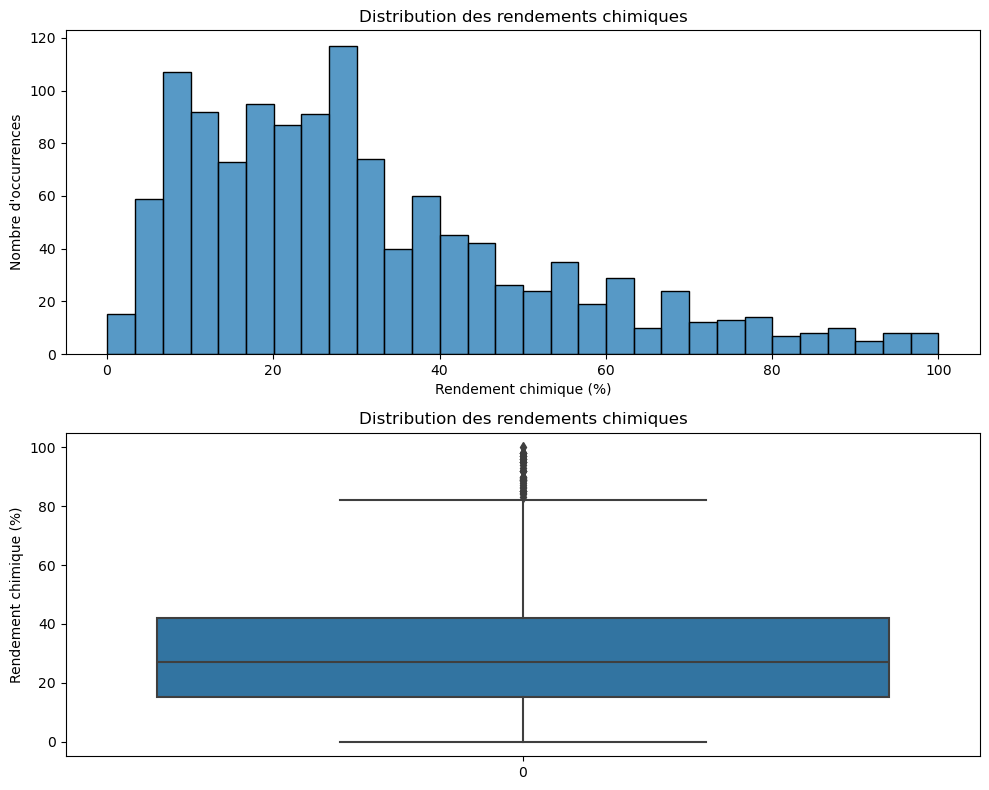

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création de la figure et des axes pour les subplots
fig, axs = plt.subplots(2,1, figsize=(10,8))

# Tracé de l'histogramme sur le premier subplot
sns.histplot(data=df, x="yield", bins=30, ax=axs[0])
axs[0].set_xlabel('Rendement chimique (%)')
axs[0].set_ylabel("Nombre d\'occurrences")
axs[0].set_title('Distribution des rendements chimiques')

# Tracé du boxplot sur le deuxième subplot
sns.boxplot(df["yield"], ax=axs[1])
axs[1].set_ylabel('Rendement chimique (%)')
axs[1].set_title('Distribution des rendements chimiques')

# Ajustement de l'espacement entre les subplots
plt.tight_layout()

# Affichage des graphiques
plt.show()


## Fingerprint DRFP

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
# Obtenir les fingerprints DRFP 
X, mapping = DrfpEncoder.encode(df["SMILES"].values, mapping=True, n_folded_length=2048, radius=3, rings=True)

In [10]:
# Transformer X en tableau array
X = np.asarray(X, dtype=np.float32)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
X.shape

(1249, 2048)

In [26]:
 # Remise en DataFaame pour le faire passer dans mes modèles.
X = pd.DataFrame(X)  

In [12]:
# Obtention de la target
target = df['yield'] / 100 # Obtention de la target

In [13]:
target

0       0.0005
1       0.0100
2       0.0200
3       0.0210
4       0.0250
         ...  
1244    0.9800
1245    0.9800
1246    0.9800
1247    0.9800
1248    1.0000
Name: yield, Length: 1249, dtype: float64

## Model

In [18]:
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statistics import mean, stdev

### Model_random_forest_regression

In [19]:
def random_forest_regression(X, y):
    rmse_scores = []
    r2_scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model = RandomForestRegressor(n_estimators=120, max_depth=25)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        #print(f"Iteration {i}: RMSE = {rmse:.3f}, R^2  = {r2:.3f}")
    # Retourner la moyenne et l'écart-type des scores
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)
    
    print("\nAverage performance of test set at 10 split")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statistics import mean, stdev

def statistics_for_the_training_set_with_5CV_RFR(X, y):
    r2_scores = []
    rmse_scores = []
    
    for i in range(10):
        X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
        X_tr.reset_index(drop=True, inplace=True)
        y_tr.reset_index(drop=True, inplace=True)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        fold_r2_scores = []
        fold_rmse_scores = []
        
        for train_index, test_index in cv.split(X_tr):
            X_train, X_test = X_tr.loc[train_index].values, X_tr.loc[test_index].values
            y_train, y_test = y_tr.loc[train_index].values, y_tr.loc[test_index].values
            
            model = RandomForestRegressor(n_estimators=120, max_depth=25)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            fold_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            fold_r2_scores.append(r2_score(y_test, y_pred))
        
        # Moyennes et écarts-types des scores pour chaque pli
        rmse_scores.append(mean(fold_rmse_scores))
        r2_scores.append(mean(fold_r2_scores))
    
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)


### Model CatBoost

In [21]:
# Importer CatBoost après l'installation
import catboost

In [22]:
def catboost_regression(X, y):
    rmse_scores = []
    r2_scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model = catboost.CatBoostRegressor(learning_rate=0.02, l2_leaf_reg=9.5, depth=7, silent=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        #print(f"Iteration {i}: RMSE = {rmse:.3f}, R2 = {r2:.3f}")
    
    # Retourner la moyenne et l'écart-type des scores
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)
    
    print("\nAverage performance of test set at 10 split")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statistics import mean, stdev

def statistics_for_the_training_set_with_5CV_catBoost(X, y):
    r2_scores = []
    rmse_scores = []
    
    for i in range(10):
        X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
        X_tr.reset_index(drop=True, inplace=True)
        y_tr.reset_index(drop=True, inplace=True)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        fold_r2_scores = []
        fold_rmse_scores = []
        
        for train_index, test_index in cv.split(X_tr):
            X_train, X_test = X_tr.loc[train_index].values, X_tr.loc[test_index].values
            y_train, y_test = y_tr.loc[train_index].values, y_tr.loc[test_index].values
            
            model = catboost.CatBoostRegressor(learning_rate=0.02, l2_leaf_reg=9.5, depth=7, silent=True)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            fold_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            fold_r2_scores.append(r2_score(y_test, y_pred))
        
        # Moyennes et écarts-types des scores pour chaque pli
        rmse_scores.append(mean(fold_rmse_scores))
        r2_scores.append(mean(fold_r2_scores))
    
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)


## Result Model

In [28]:
import time
import pandas as pd
from tqdm import tqdm

def run_and_compare_models(X, y):
    models = {
        "Random_Forest": random_forest_regression,
        "Random_Forest_Kfold": statistics_for_the_training_set_with_5CV_RFR,
        "CatBoost": catboost_regression,
        "CatBoostKflod": statistics_for_the_training_set_with_5CV_catBoost
    }
    
    results = []
    
    for model_name, model_func in tqdm(models.items(), desc="Running models"):
        start_time = time.time()
        rmse_avg, rmse_std, r2_avg, r2_std = model_func(X, y)
        end_time = time.time()  # Arrêter le chronomètre
        elapsed_time = end_time - start_time
        results.append({
            "Model": model_name,
            "RMSE Avg": rmse_avg,
            "RMSE Std": rmse_std,
            "R^2 Avg": r2_avg,
            "R^2 Std": r2_std,
            "Time (s)": elapsed_time  # Ajouter le temps écoulé à chaque entrée
        })
        
    results_df = pd.DataFrame(results)
    return results_df


In [29]:
results_df_ = run_and_compare_models(X, target)

Running models: 100%|██████████| 4/4 [11:26<00:00, 171.69s/it]


In [30]:
results_df_.to_csv('Resultat_Df_DRFP.csv')

In [31]:
results_df_

,Model,RMSE Avg,RMSE Std,R^2 Avg,R^2 Std,Time (s)
0,Random_Forest,0.142515,0.008574,0.539910,0.065287,58.062376
1,Random_Forest_Kfold,0.147139,0.003013,0.517113,0.022811,221.555621
2,CatBoost,0.143056,0.006422,0.537153,0.053866,71.103750
3,CatBoostKflod,0.143922,0.002019,0.539594,0.017240,336.047481


## XGboost

In [32]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score
from sklearn.model_selection import learning_curve

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

In [34]:
model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.01,
                max_depth=12,
                min_child_weight=6,
                colsample_bytree=0.6,
                subsample=0.8,
                random_state=42,
            )

In [35]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print("Root Mean Squared Error:", rmse) 
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='validation_score')
    plt.legend()
     

Mean Squared Error: 0.02226718458071585
R-squared: 0.5570364152524707
Root Mean Squared Error: 0.14922193062923375


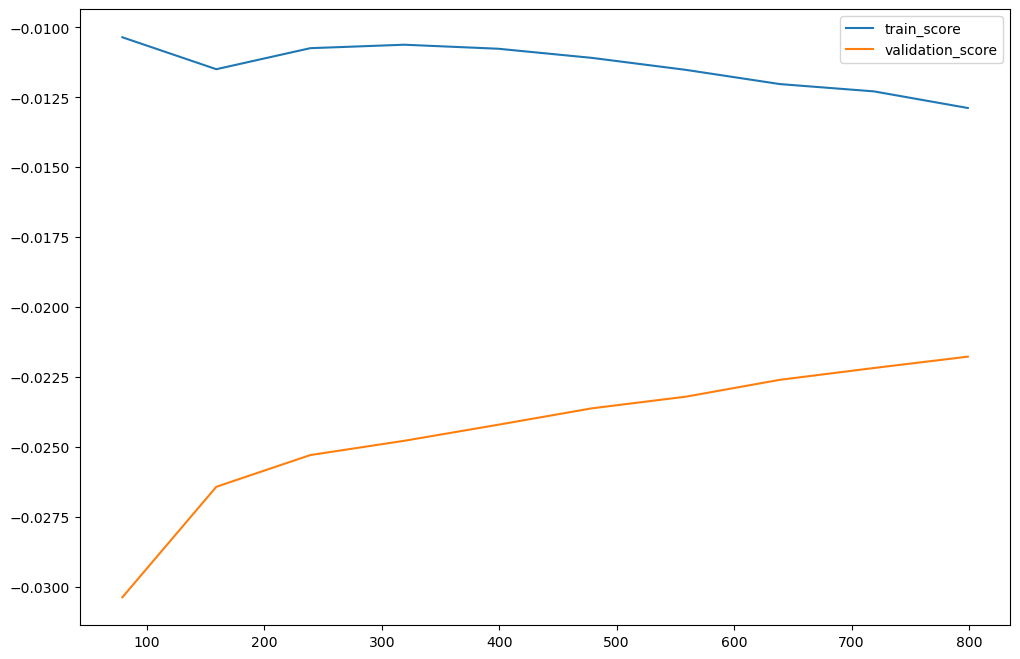

In [36]:
evaluation(model)